In [ ]:
# pip install scikit-learn-intelex 
# run if don't have

In [1]:
import pandas as pd
import pickle
import numpy as np


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.preprocessing import normalize, StandardScaler

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# OPTICS

Load data:

In [2]:
y_LinearSVC = pd.read_pickle('./data/y_pred_LinearSVC.pkl')
y_LogReg = pd.read_pickle('./data/y_pred_LogReg.pkl')
y_RidgeReg = pd.read_pickle('./data/y_pred_RidgeReg.pkl')
X = pd.read_pickle('./data/unlabeled_behavior.pkl')
embeddings = pd.read_pickle('./data/embedding.pkl')

Define plotting function:

In [48]:
# plot_with_ys(x1, x2, names, y_class, y_cluster=None, ext_names=False)
# Generates a 2d plot of the given data. If only y_class is given, data points will be colored by
# classification. If y_cluster is also given, data points will be colored by cluster label with shapes
# corresponding to classification. Intended for use with embeddings generated by TSNE. Plots with
# extended names will go to a scratch folder so we can compare selections of parameters for TSNE.
# Once we've chosen parameters these will be used through all future plots so the plots that go
# into our report can go without extended names.
# Variables:
# x1        -  array representing the position on the x-axis of each point in a 2d embedding from TSNE
# x2        -  array representing the position on the y-axis of each point in a 2d embedding from TSNE
# names     -  an array of string names for the classification algorithm used (index 0) and
#              the clustering algorithm used (index 1). If ext_names=True, also includes the 
#              perplexity (index 2) and the distance metric (index 3). For use in plotting.
# y_class   -  an array of classifications from a supervised model
# y_cluster -  an array of cluster labelings (default: None)
# ext_names -  whether to look for extended names for the plot (default: False)
@mpl.rc_context({'image.cmap': 'tab10', 'figure.figsize': [12.0, 8.0]})
def plot_with_ys(x1, x2, names, y_class, y_cluster=None, ext_names=False):
    
    fig, ax = plt.subplots()
    
    if y_cluster is not None: #plotting comparison between classification and clustering
        
        #create a colormap of the correct size, doing this bc just giving 'tab10' to the cmap
        #parameter gives colors from each end of the palette instead of sequentially
        colors = mpl.colors.ListedColormap(plt.get_cmap('tab10')(np.arange(len(np.unique(y_cluster)))))
        
        #plot the two predicted classes with different markers, coloring by cluster assignment
        x1_normal = [a for a,b in zip(x1, y_class) if b == 0]
        x2_normal = [a for a,b in zip(x2, y_class) if b == 0]
        scatter1 = ax.scatter(x1_normal, x2_normal, marker='|', cmap=colors,
                              c=y_cluster[np.argwhere(y_class == 0)])
        
        x1_outlier = [a for a,b in zip(x1, y_class) if b == 1]
        x2_outlier = [a for a,b in zip(x2, y_class) if b == 1]
        scatter2 = ax.scatter(x1_outlier, x2_outlier, marker='_', cmap=colors,
                              c=y_cluster[np.argwhere(y_class == 1)])
        
        #create a legend for differentiating between colors
        legend1 = ax.legend(*scatter1.legend_elements(), loc="lower left", title="Clusters")
        ax.add_artist(legend1)
        
        #create a legend from scratch for differentiating between markers
        vline = mlines.Line2D([], [], color='black', marker='|', linestyle='None',
                              markersize=10, label='0 (normal)')
        hline = mlines.Line2D([], [], color='black', marker='_', linestyle='None',
                              markersize=10, label='1 (outlier)')
        legend2 = ax.legend(handles=[vline, hline], loc="lower right", title="Classes")
        
        #insert given names to title and filename
        if ext_names: #with names for perplexity and distance metric
            plt.title('TSNE '+names[1]+' Clusterings & ' +names[0]+' Classifications p'
                      +names[2]+' '+names[3])
            filename = './figures/scratch/TSNE_'+names[1]+'_'+names[0]+'_p'+names[2]+'_'+names[3]+'.png'
        else: #without names for perplexity and distance metric
            plt.title('TSNE '+names[1]+' Clusterings & ' +names[0]+' Classifications')
            filename = './figures/TSNE_'+names[1]+'_'+names[0]+'.png'

        plt.savefig(filename, format='png')
    else: #plotting only a classification
        colors = mpl.colors.ListedColormap(plt.get_cmap('tab10')(np.arange(2)))
        scatter = ax.scatter(x1, x2, marker='.', c=y_class, cmap=colors)
        legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
        
        #insert given names to title and filename
        if ext_names: #with names for perplexity and distance metric
            plt.title('TSNE '+names[0]+' Classifications p'+names[2]+' '+names[3])
            filename = './figures/scratch/TSNE_'+names[0]+'_p'+names[2]+'_'+names[3]+'.png'
        else: #without names for perplexity and distance metric
            plt.title('TSNE '+names[0]+' Classifications')
            filename = './figures/TSNE_'+names[0]+'.png'
            
        plt.savefig(filename, format='png')

    plt.show()

Define a model:

In [4]:
# max_eps

# our data has 33837 rows/data points
optics_model = OPTICS(min_samples = 5, xi = 0.05, min_cluster_size = 2, algorithm = 'kd_tree')
  
# training the model
optics_model.fit(X)

# Producing the labels according to the DBSCAN technique with eps = 0.5
labels1 = cluster_optics_dbscan(reachability = optics_model.reachability_,
                                   core_distances = optics_model.core_distances_,
                                   ordering = optics_model.ordering_, eps = 0.5)
  
# Producing the labels according to the DBSCAN technique with eps = 2.0
labels2 = cluster_optics_dbscan(reachability = optics_model.reachability_,
                                   core_distances = optics_model.core_distances_,
                                   ordering = optics_model.ordering_, eps = 2)
  
# Creating a numpy array with numbers at equal spaces till the specified range
space = np.arange(len(X))
  
# Storing the reachability distance of each point
reachability = optics_model.reachability_[optics_model.ordering_] # can we explore this?
  
# Storing the cluster labels of each point
labels = optics_model.labels_[optics_model.ordering_]
  
# print(labels)

/Users/KarenLi/Desktop/Desktop.nosync/development/anaconda/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


OPTICS(algorithm='kd_tree', min_cluster_size=2)

In [29]:
# for quick inspections
# labels = optics_model.labels_
print(max(labels), '\n') #- 1 not assigned 

2397 



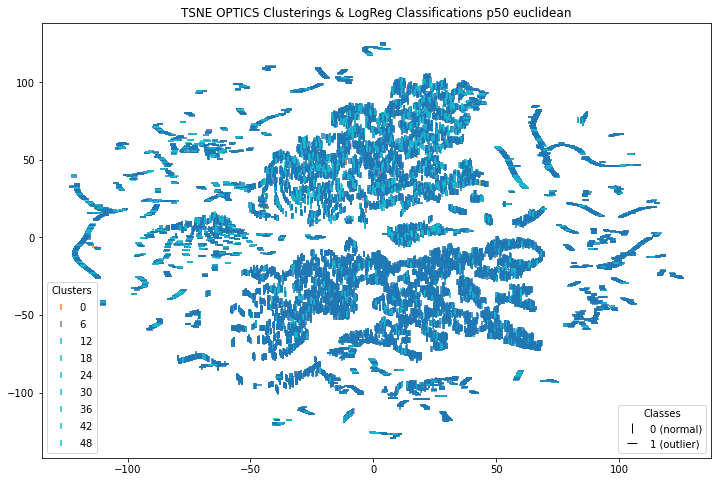

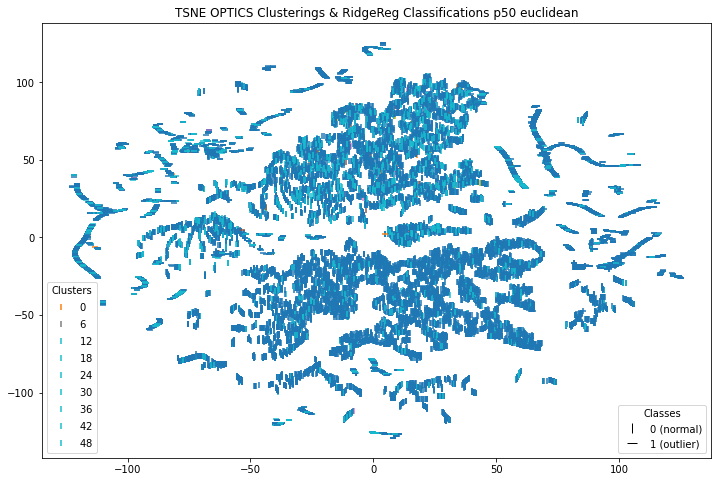

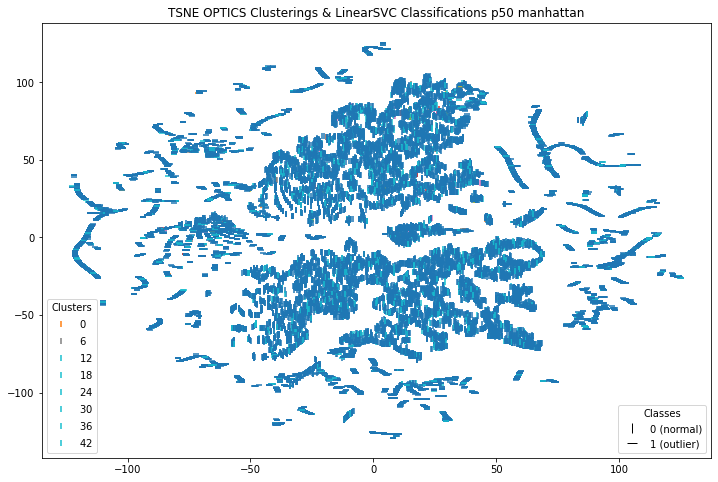

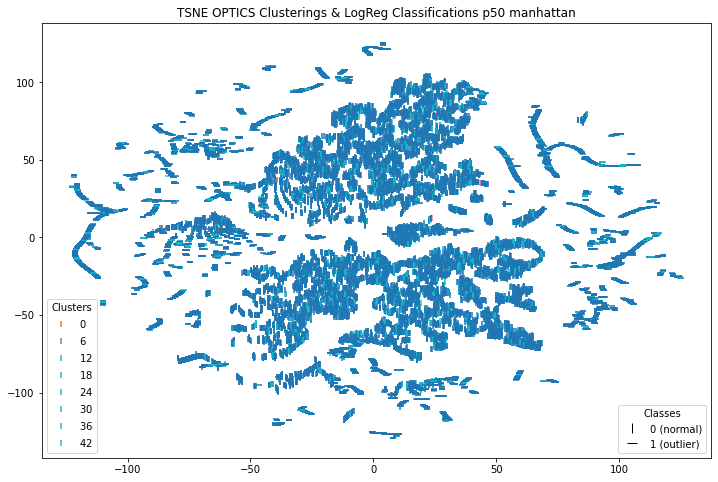

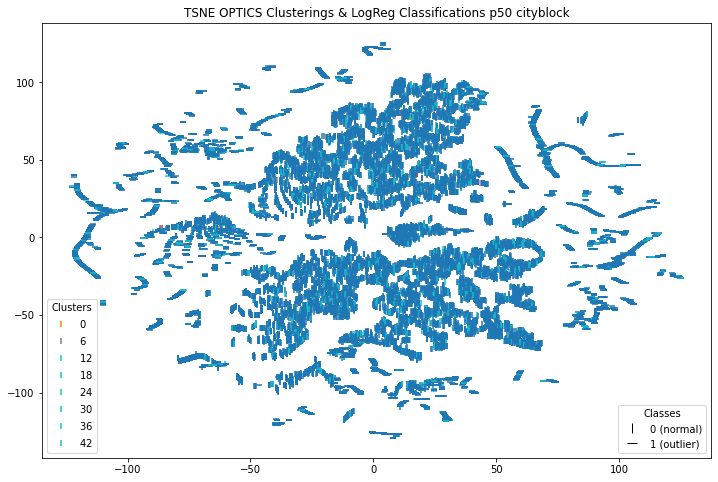

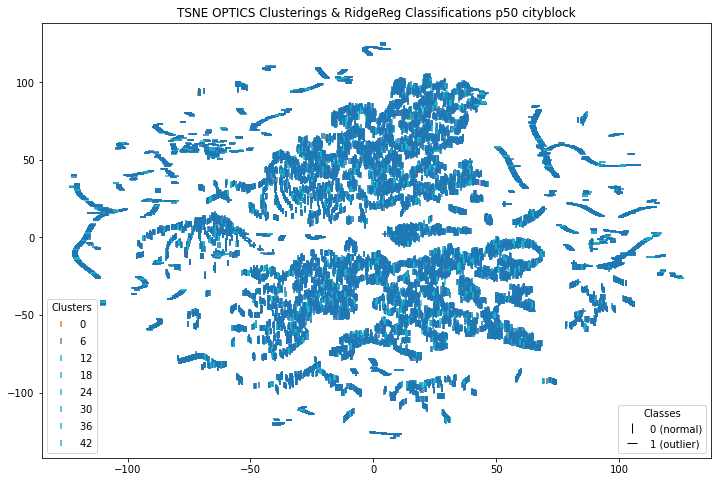

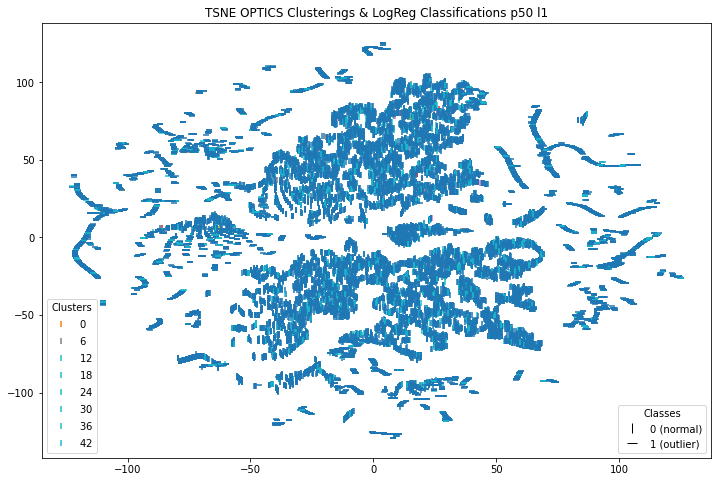

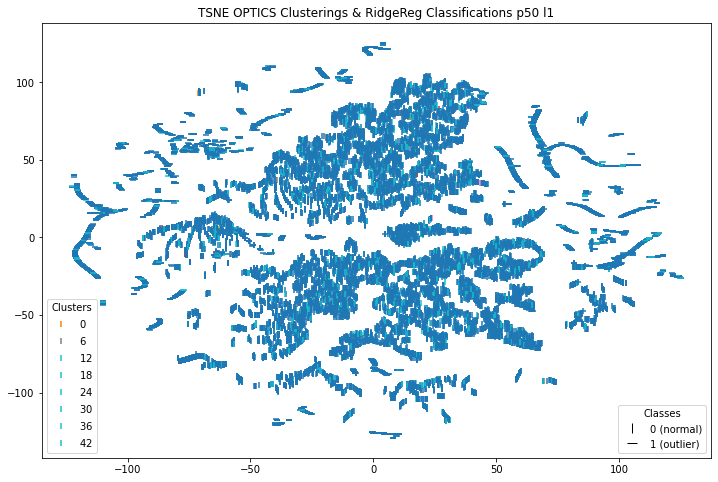

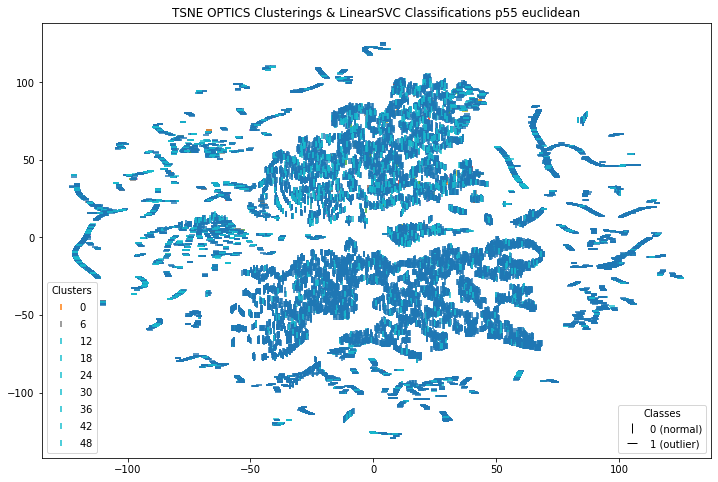

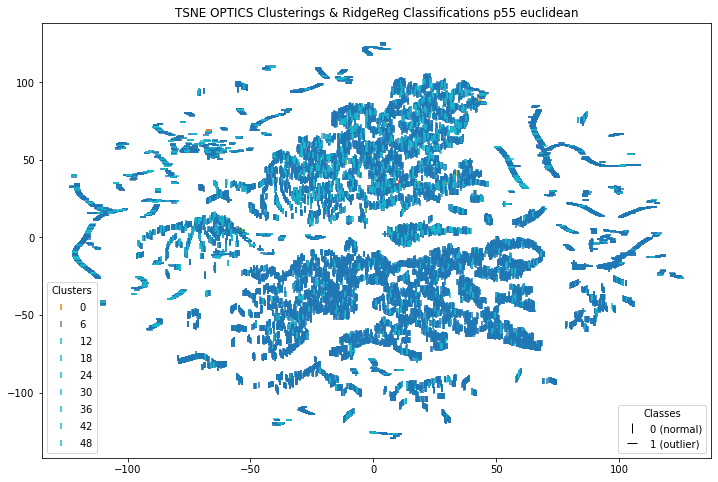

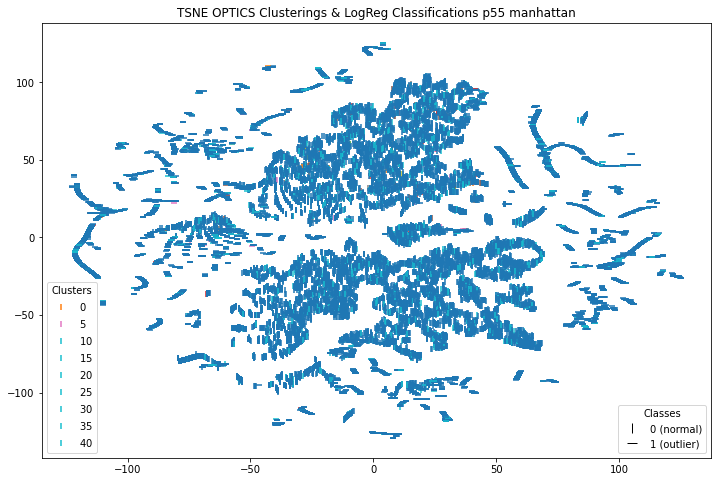

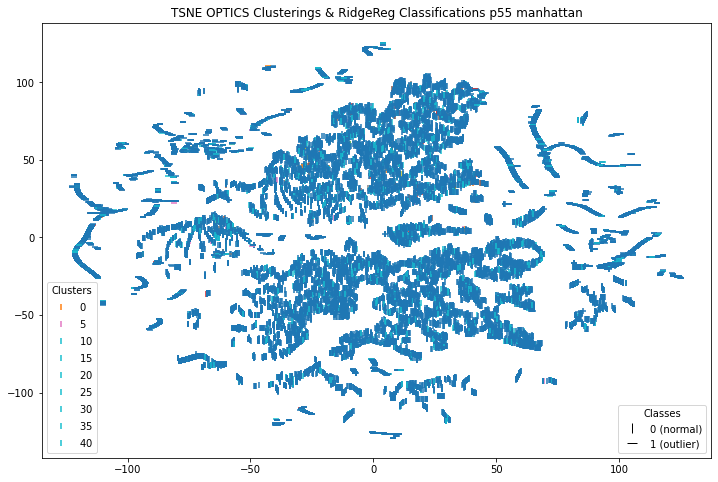

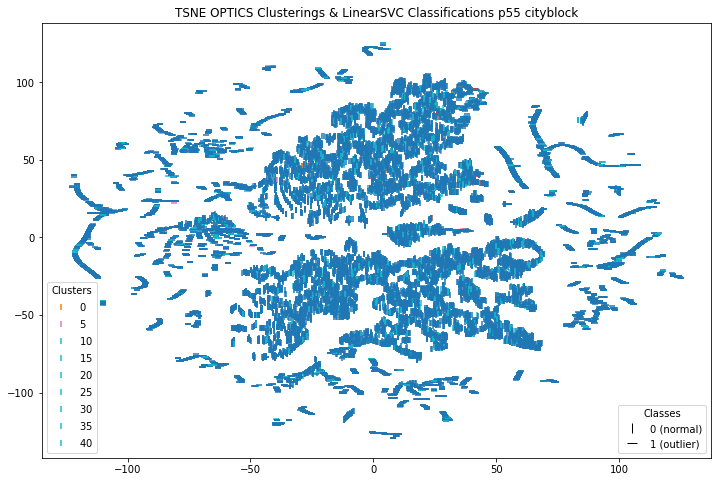

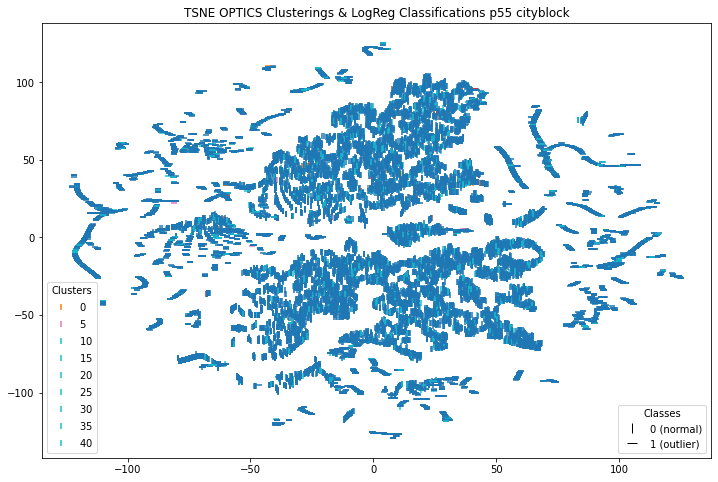

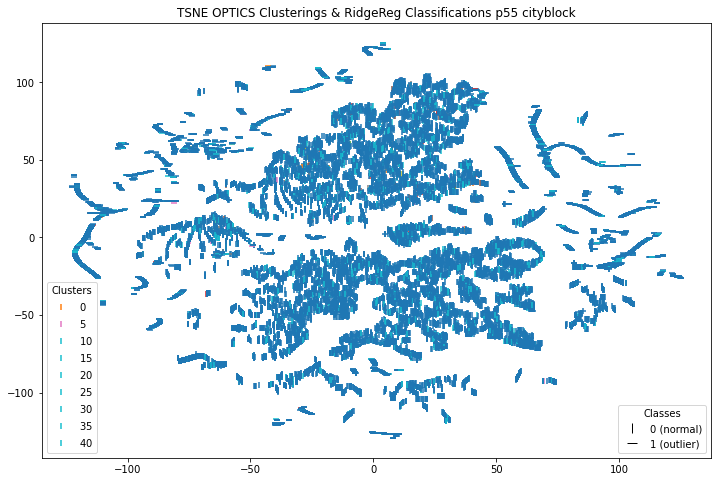

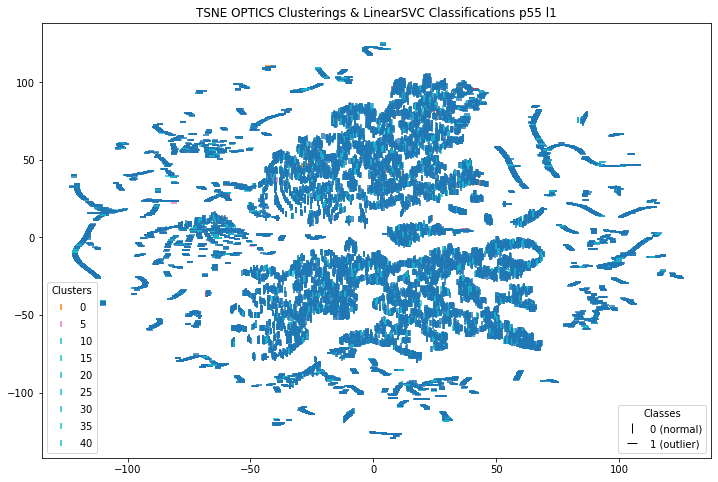

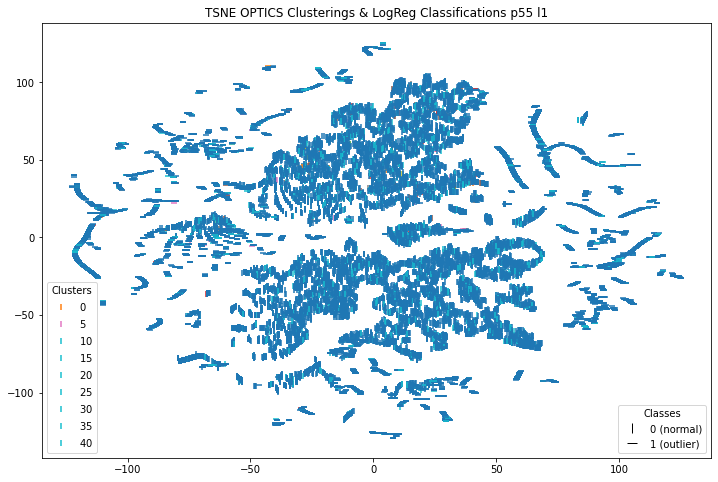

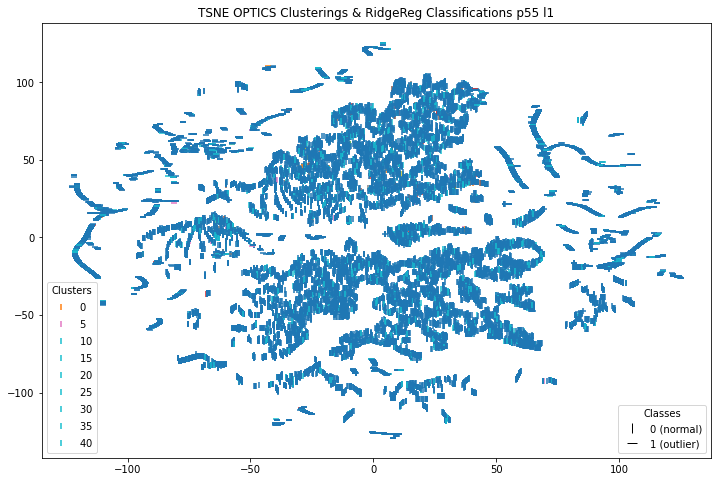

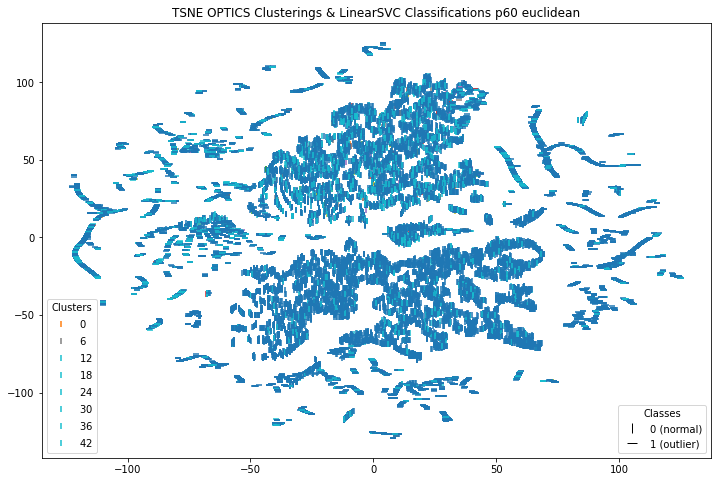

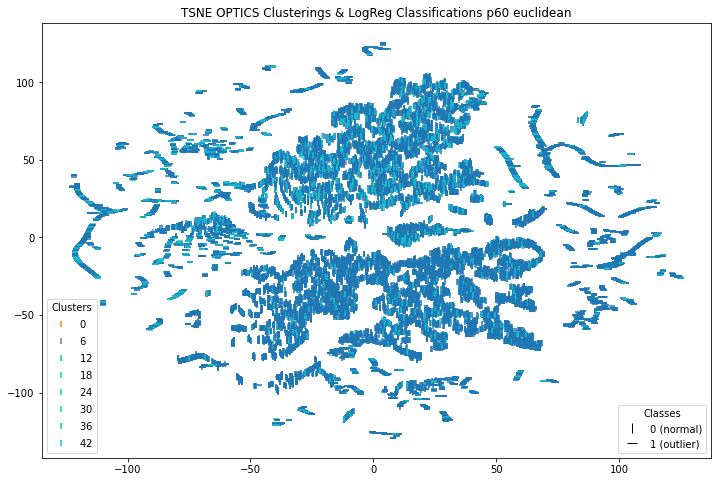

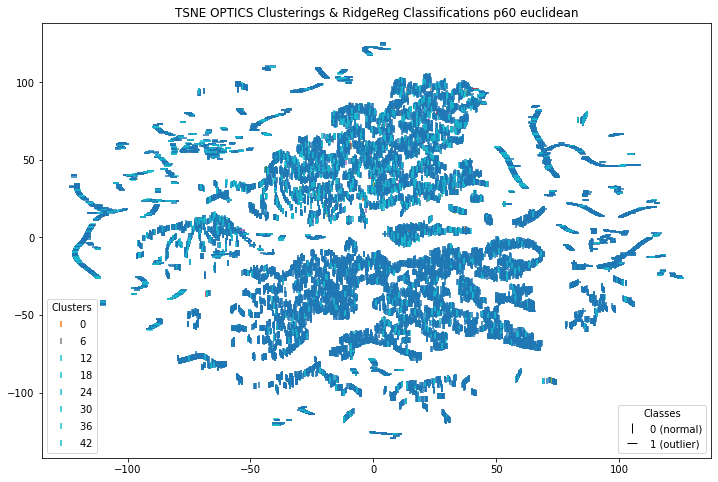

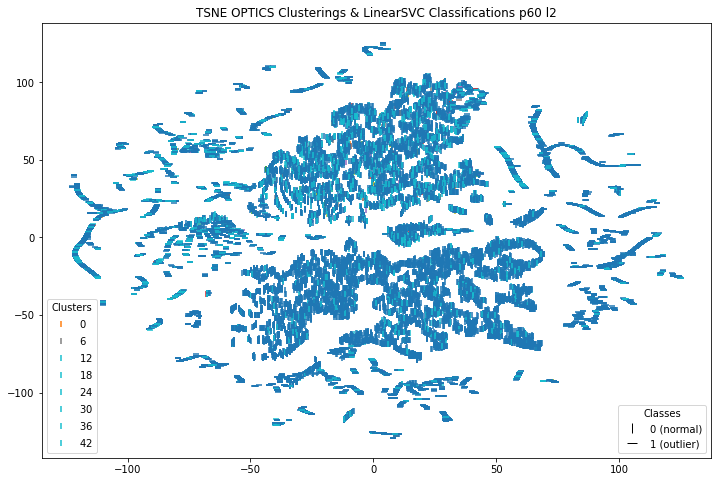

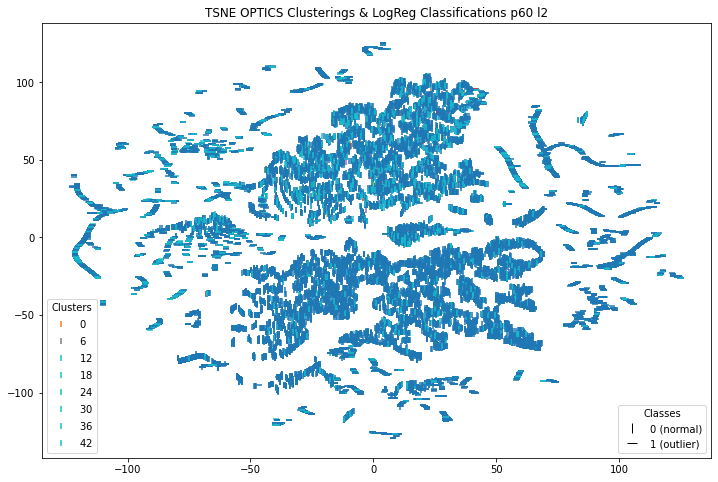

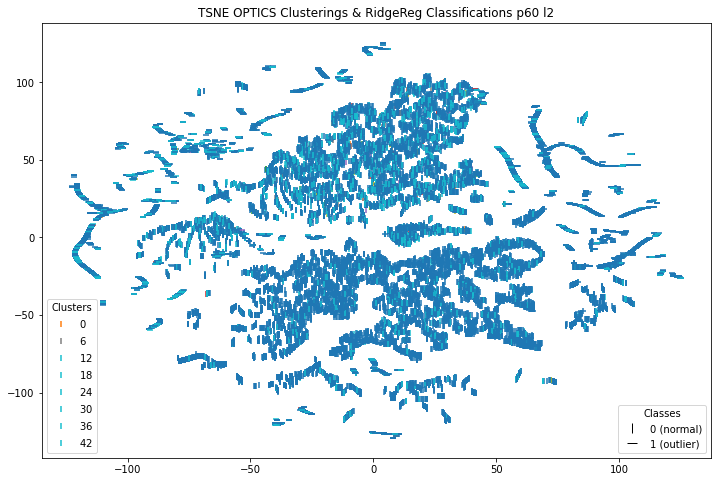

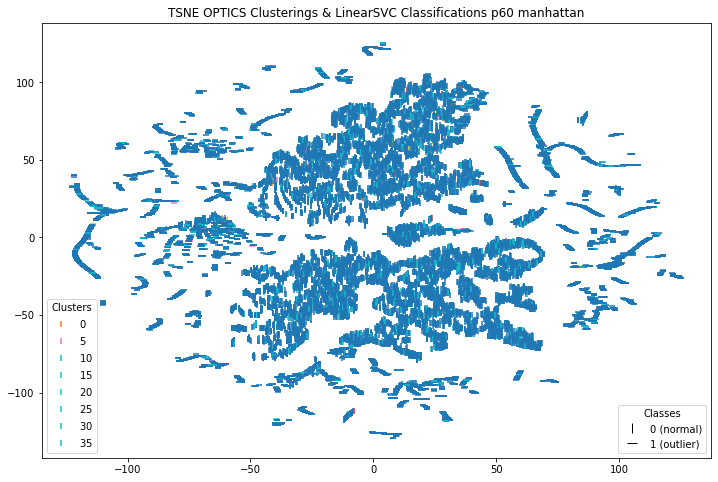

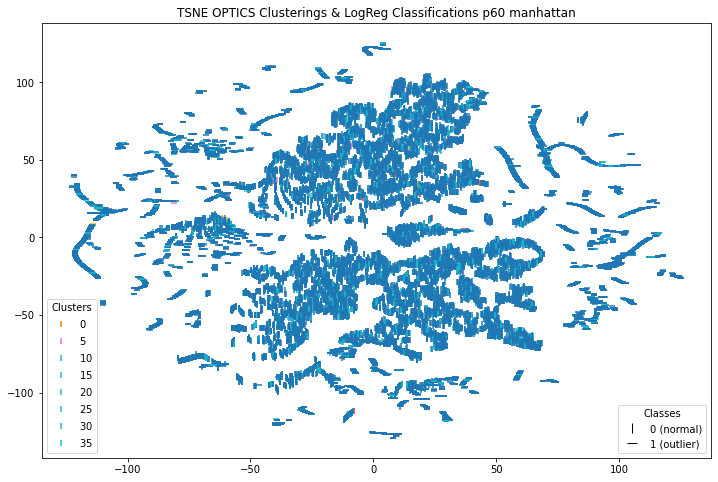

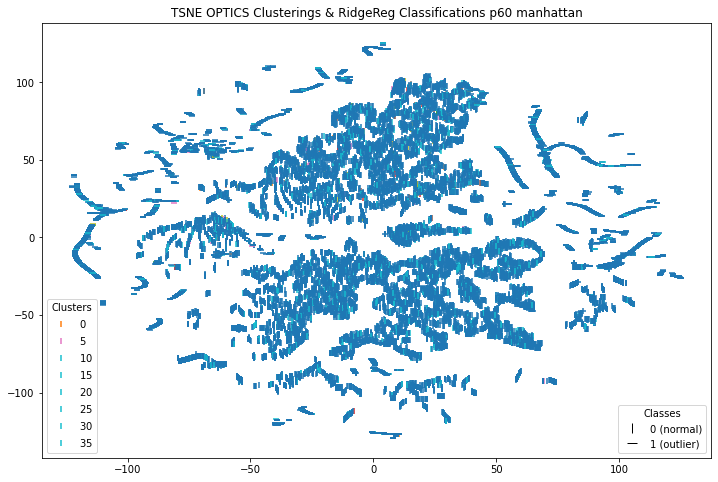

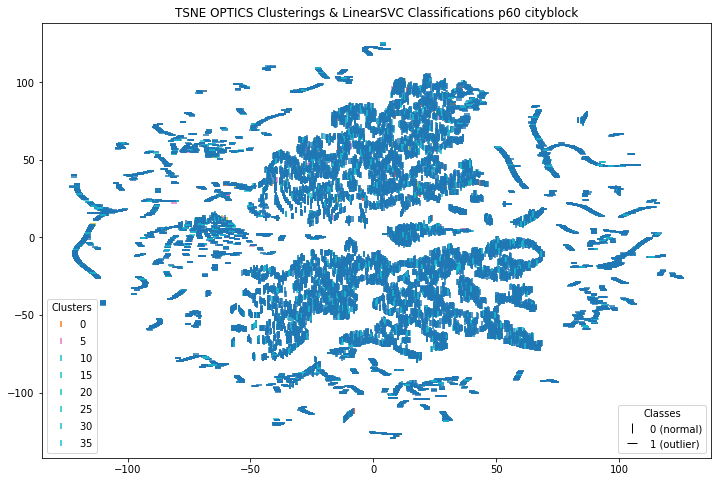

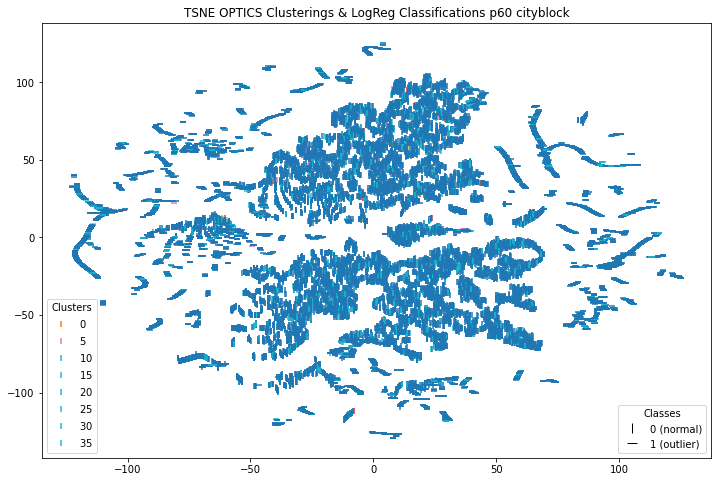

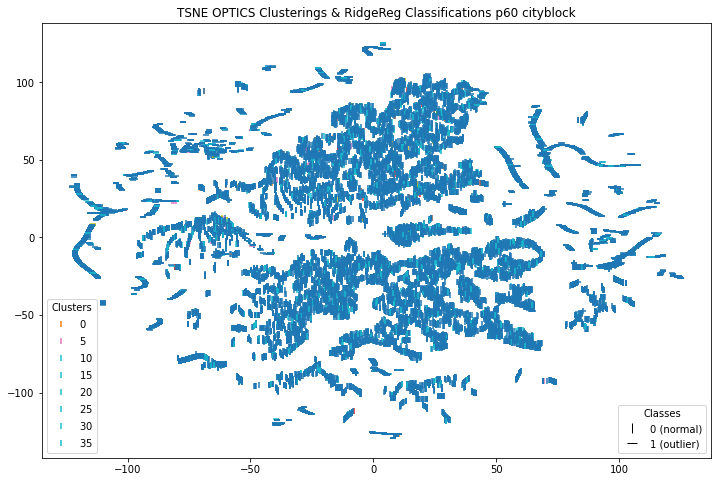

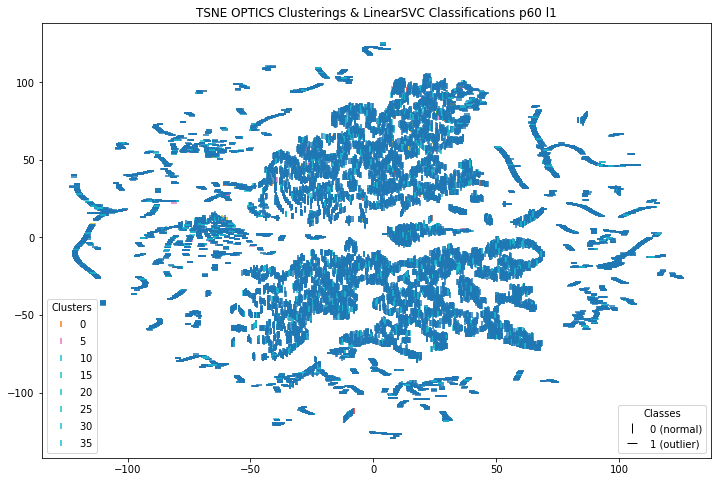

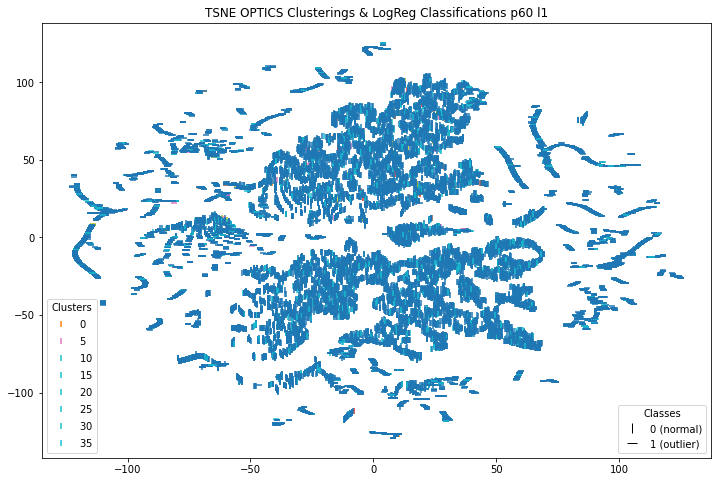

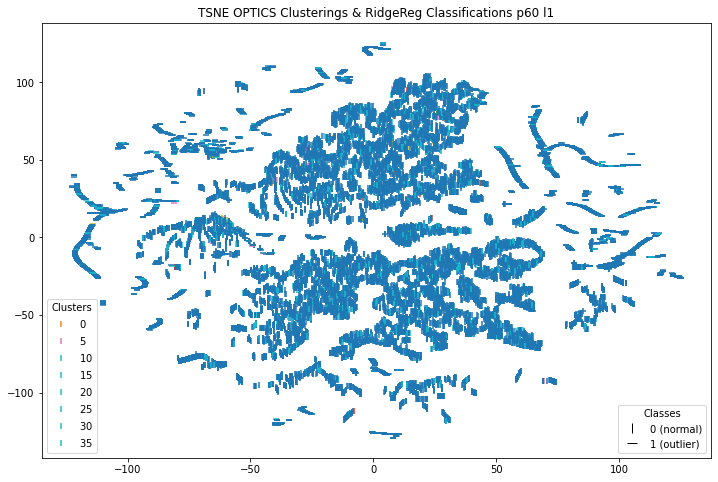

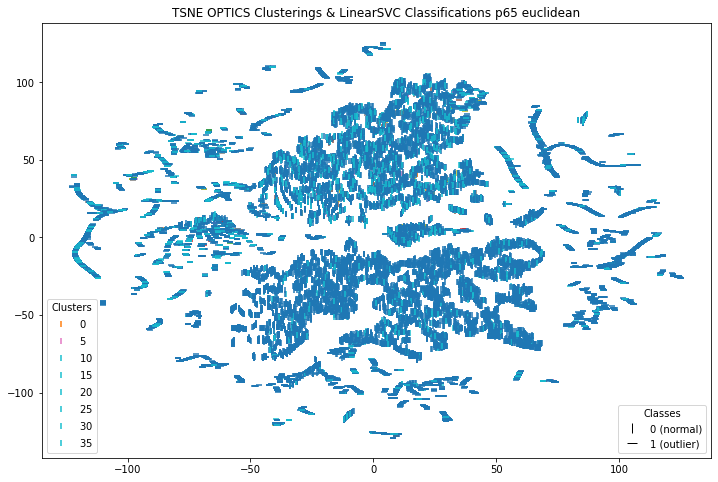

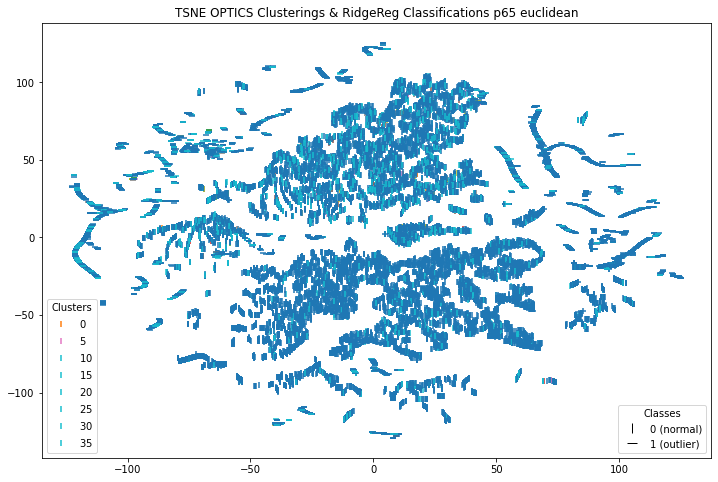

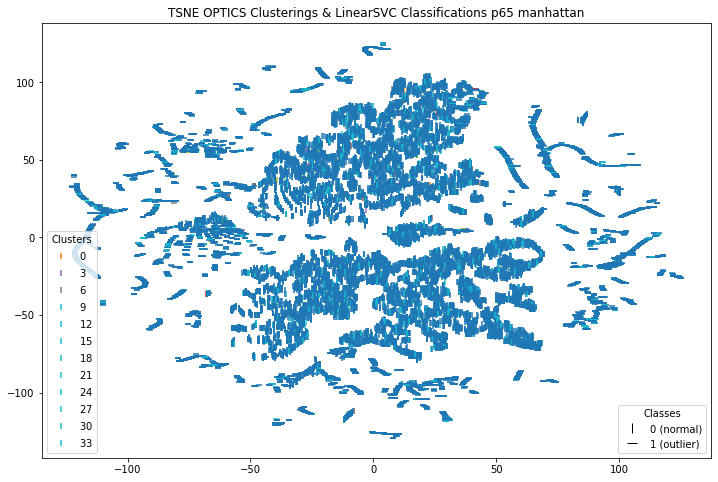

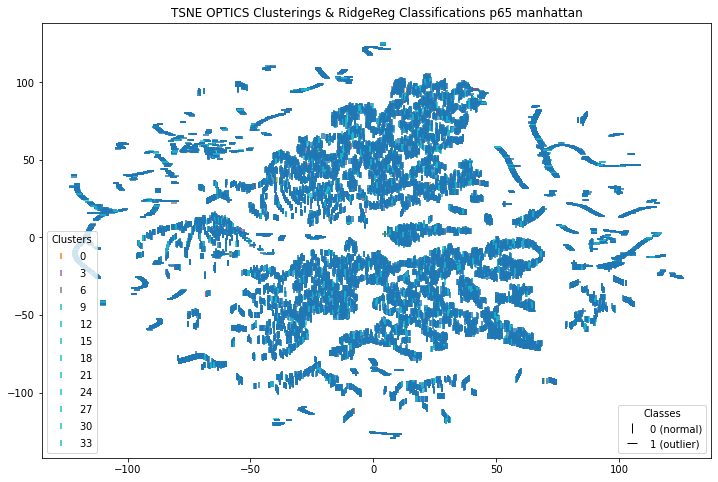

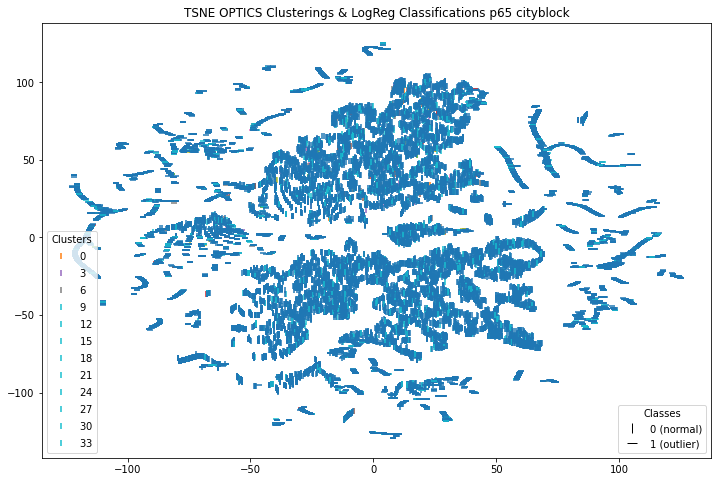

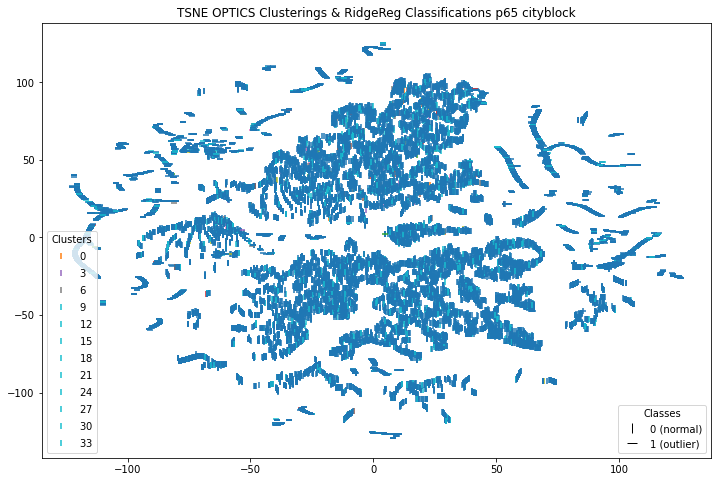

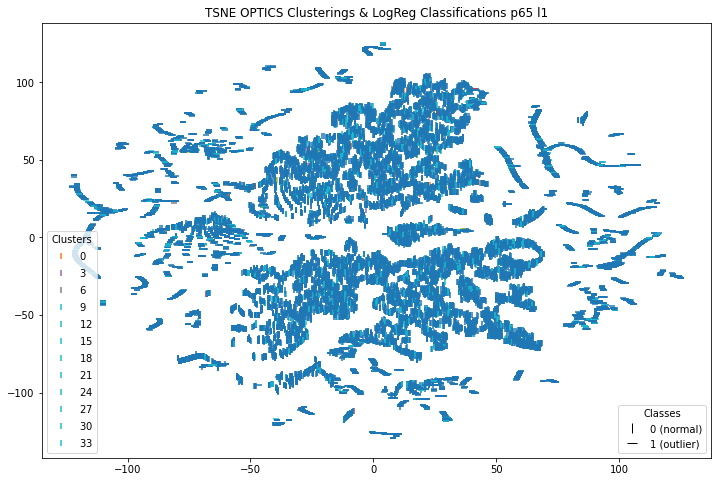

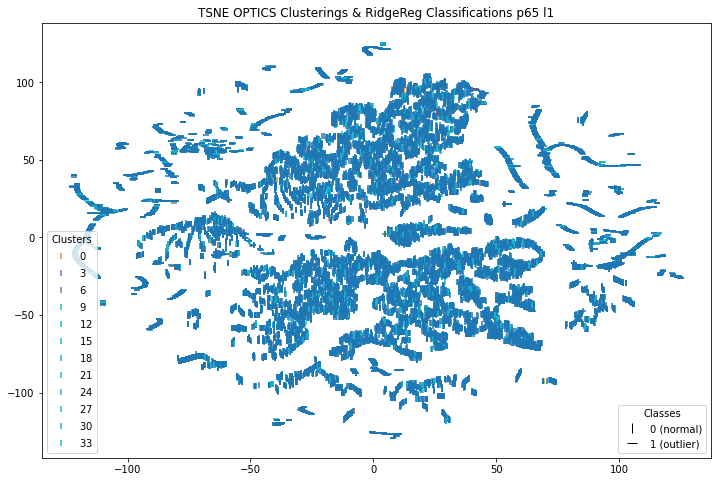

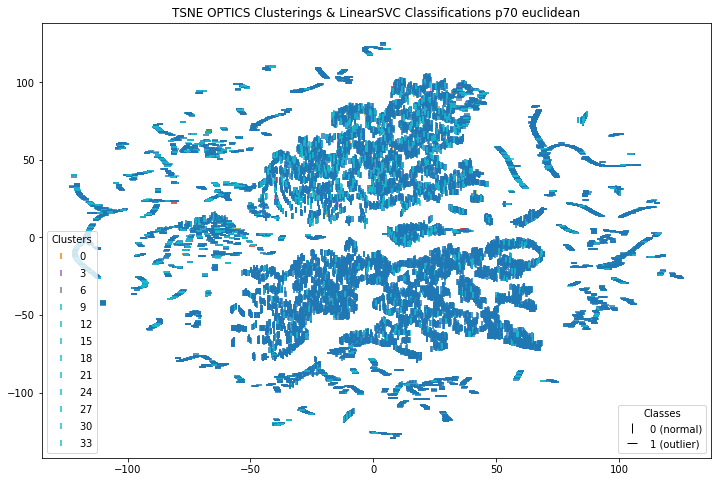

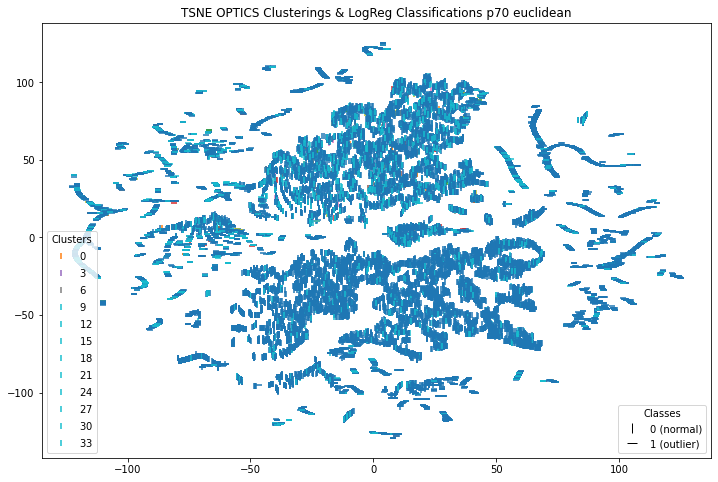

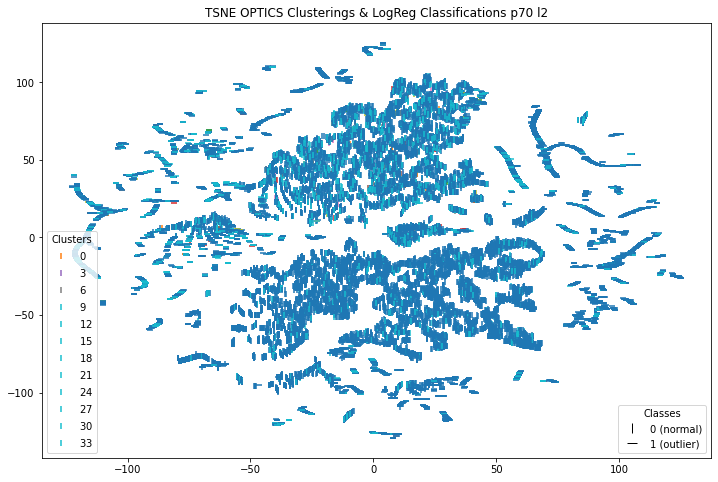

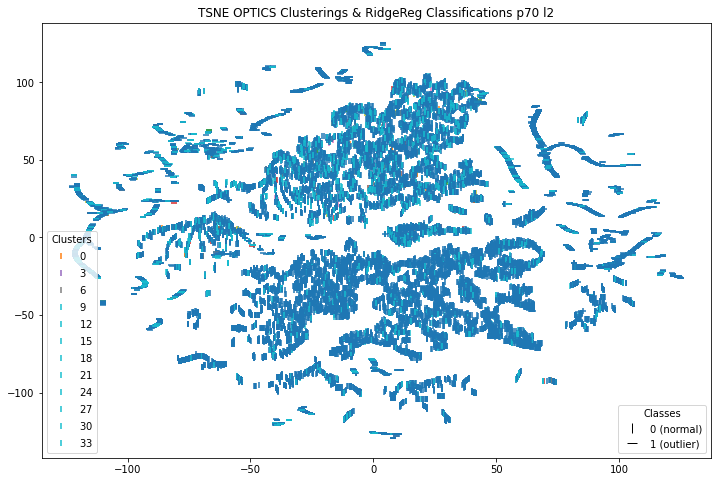

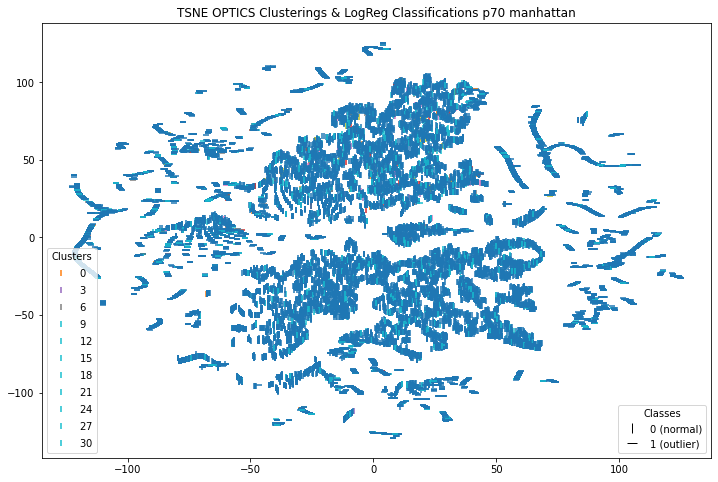

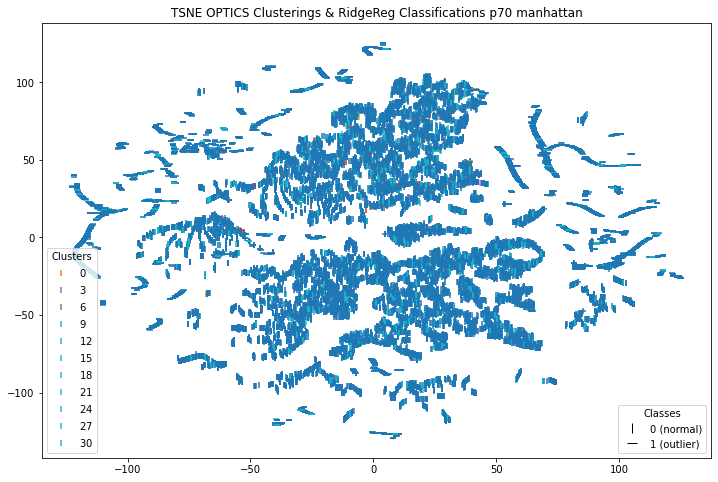

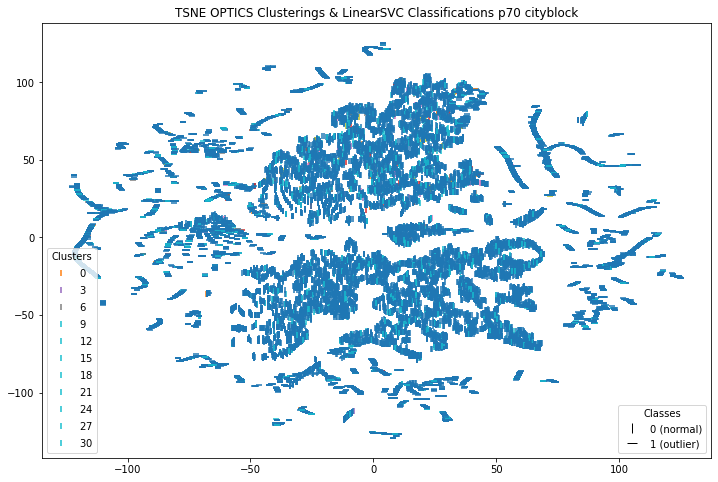

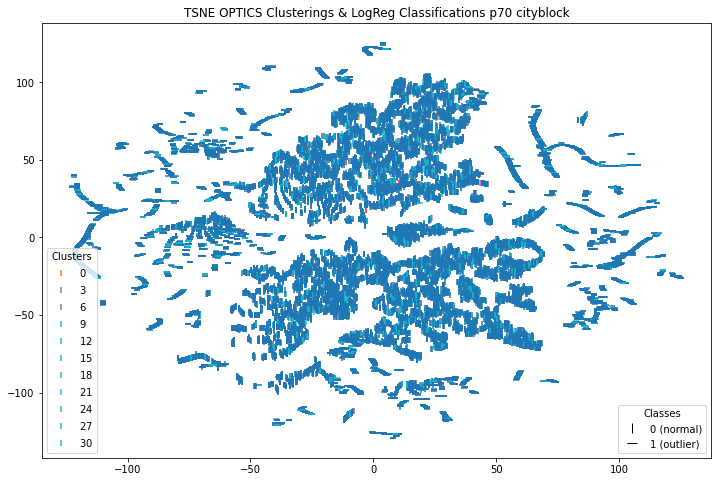

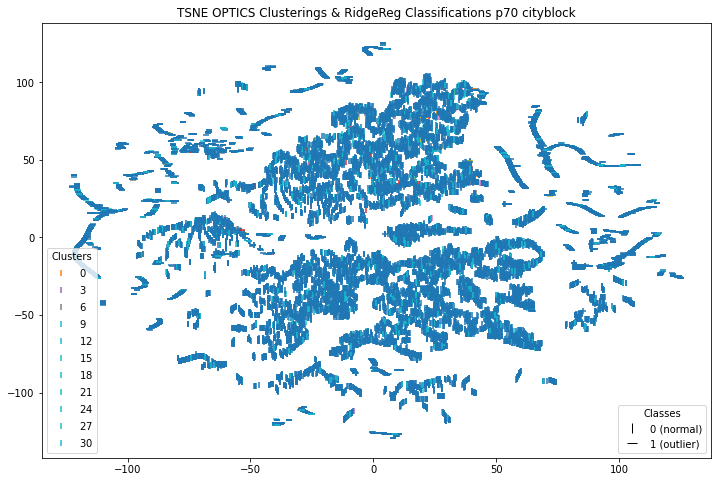

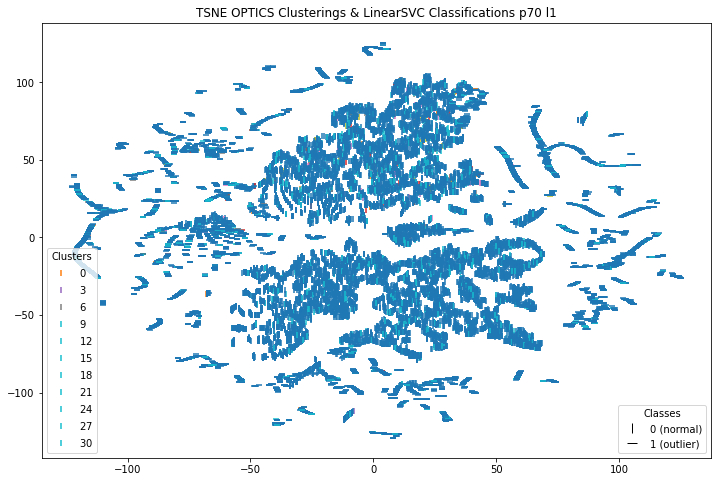

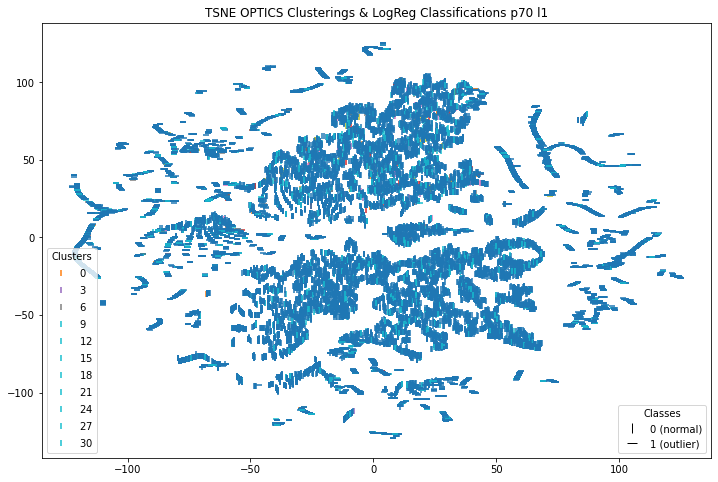

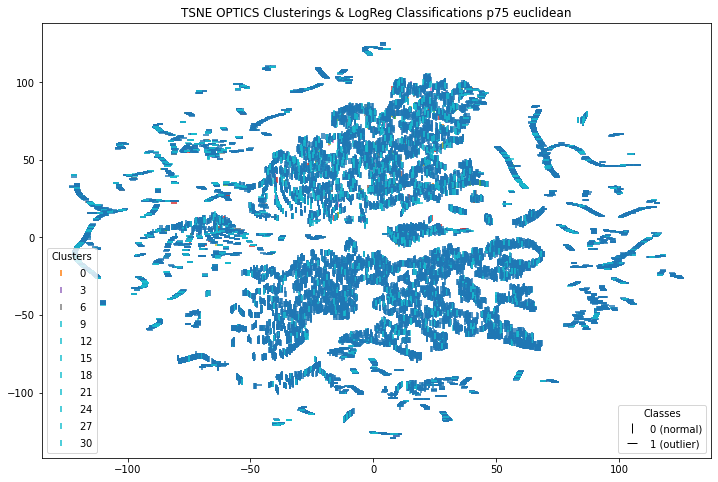

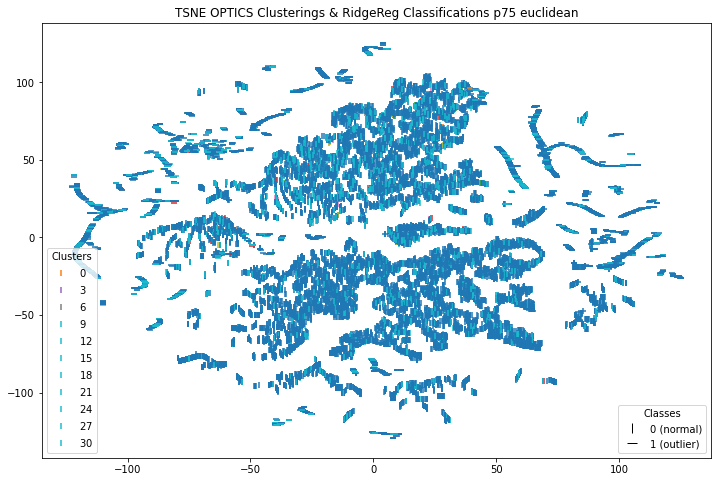

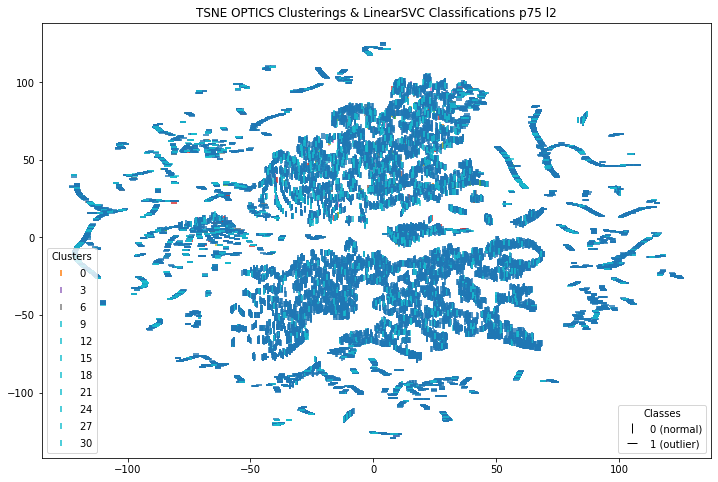

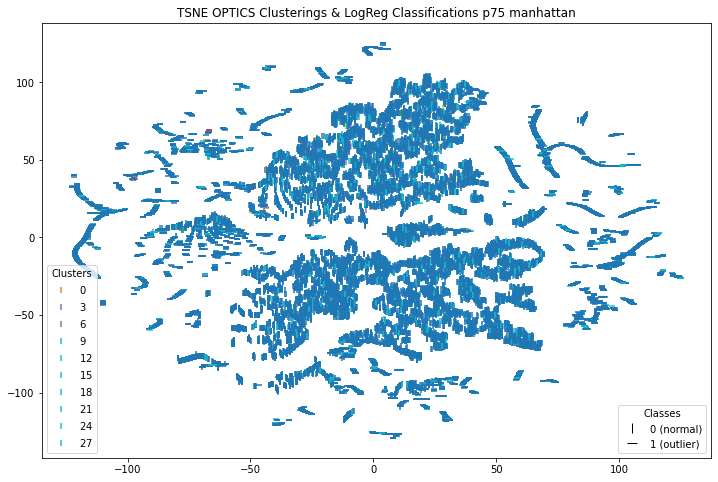

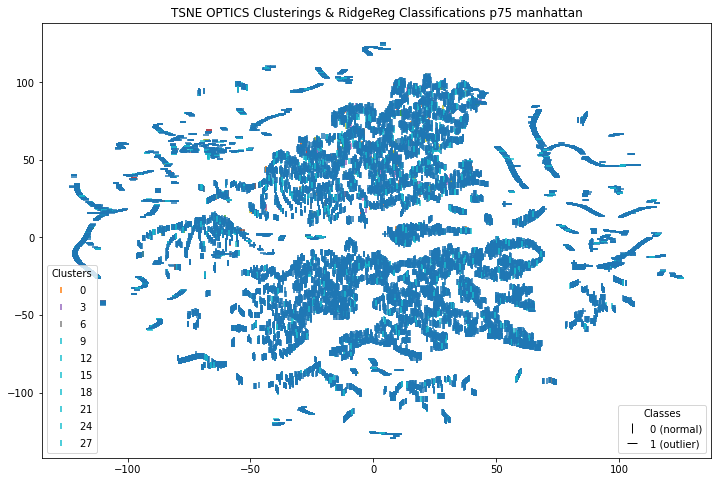

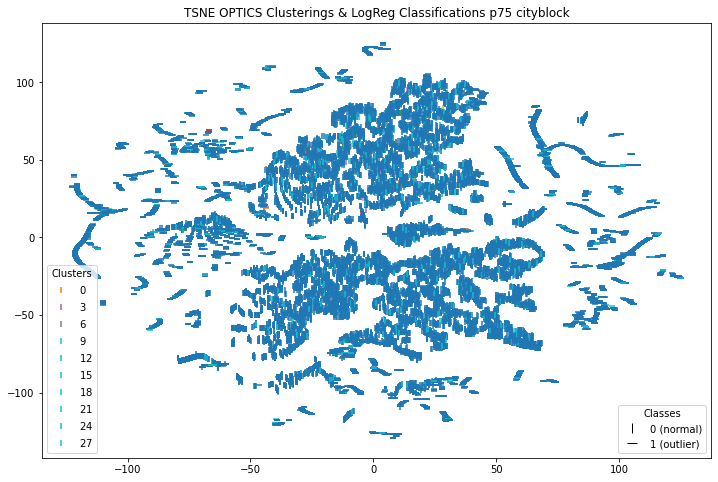

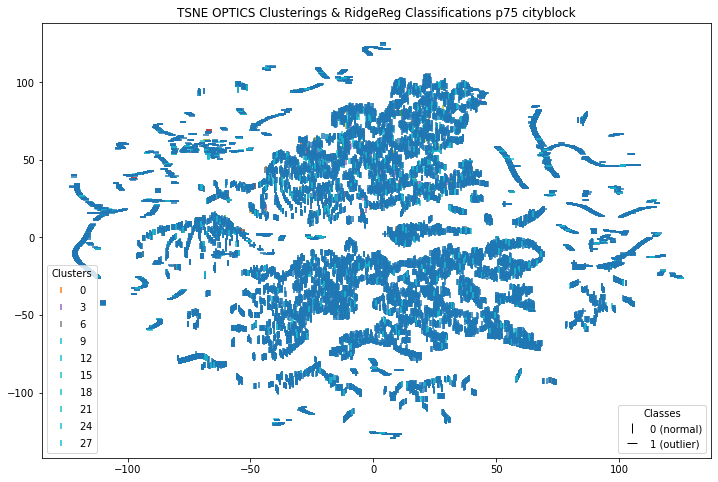

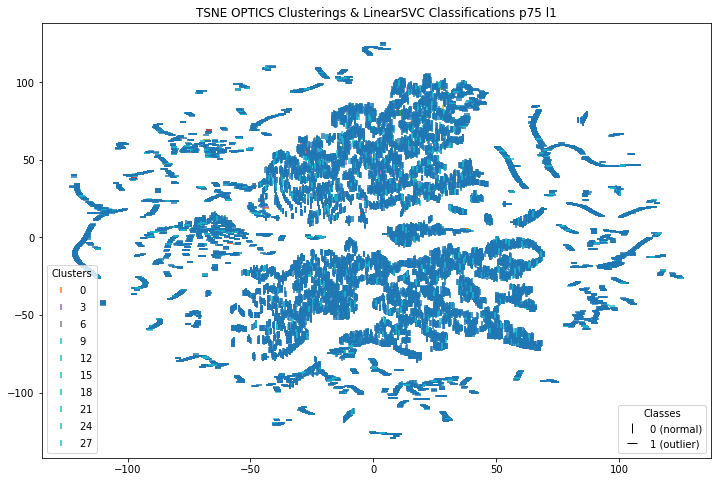

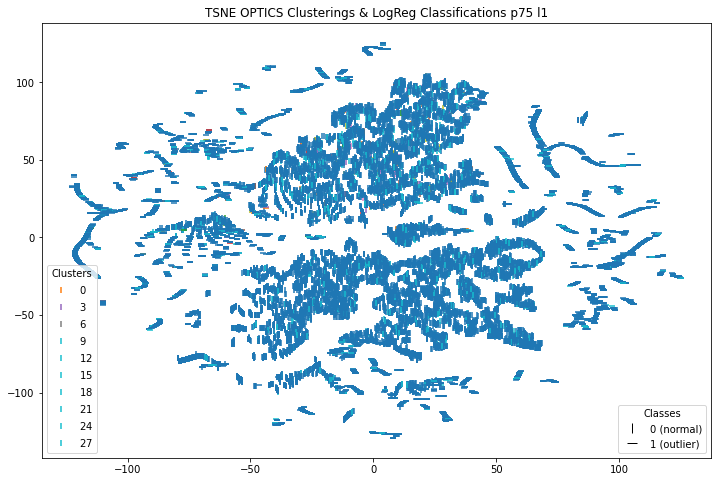

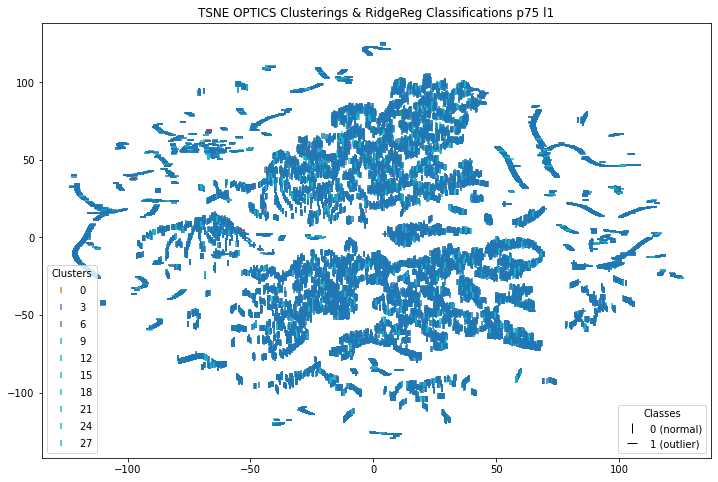

In [50]:
# test out models with several param configurations
min_samples = np.arange(50, 80, 5)
distance_metrics = ['euclidean', 'l2', 'manhattan', 'cityblock', 'l1']
# ones supported by OPTICS [‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’]
# supported distance metrics for kd_tree, got from sklearn.neighbors.VALID_METRICS['kd_tree']
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']

for s in min_samples:
    for dm in distance_metrics: 
        #for algo in algorithms:
        optics_model = OPTICS(min_samples = s, xi = 0.05, min_cluster_size = 2, algorithm = 'kd_tree', metric=dm)
        optics_model.fit(X)
        labels = optics_model.labels_[optics_model.ordering_]
        plot_with_ys(embeddings[0], embeddings[1], ['LinearSVC', 'OPTICS', str(s), dm], y_LinearSVC, 
                     labels, ext_names=True)
        plot_with_ys(embeddings[0], embeddings[1], ['LogReg', 'OPTICS', str(s), dm], y_LogReg, labels,
                    ext_names=True)
        plot_with_ys(embeddings[0], embeddings[1], ['RidgeReg', 'OPTICS', str(s), dm], y_RidgeReg, labels,
                    ext_names=True)

In [52]:
min_samples = np.arange(80, 95, 5)
distance_metrics = ['euclidean', 'l2', 'manhattan', 'cityblock', 'l1']

for s in min_samples:
    for dm in distance_metrics: 
        optics_model = OPTICS(min_samples = s, xi = 0.05, min_cluster_size = 2, algorithm = 'kd_tree', metric=dm)
        optics_model.fit(X)
        labels = optics_model.labels_[optics_model.ordering_]
        print(str(s) + ' ', dm + ' ', max(labels), '\n')

80  euclidean  27 

80  l2  27 

80  manhattan  24 

80  cityblock  24 

80  l1  24 

85  euclidean  22 

85  l2  22 

85  manhattan  23 

85  cityblock  23 

85  l1  23 

90  euclidean  22 

90  l2  22 

90  manhattan  22 

90  cityblock  22 

90  l1  22 



In [ ]:
# next step: cut out smaller clusters -> rename the clusters
# look for epsilon

## OPTICS with Gower

In [ ]:
X_gower = pd.DataFrame(gower.gower_matrix(X, cat_features=[False, False, False, False, True,
                                                           False, False, False, True]))

In [ ]:
%%capture

# with cluster_method = xi

# 35 gives about 91 clusters and 95 yields 19 clusters
min_samples = np.arange(35, 95, 5)
dm = 'euclidean'

for s in min_samples:
    #apply OPTICS with Gower distance
    optics_model = OPTICS(min_samples =s, xi = 0.05, min_cluster_size = 2, algorithm = 'kd_tree', metric=dm)
    optics_model.fit(X_gower)
    labels = optics_model.labels_[optics_model.ordering_]
    print(str(s) + ' ', dm + ' ', max(labels) + ' ', 'with Gower', '\n')

In [ ]:
# with cluster_method = dbscan
min_samples = np.arange(35, 95, 5)
dm = 'euclidean'

for s in min_samples:
    #apply OPTICS with Gower distance
    optics_model = OPTICS(min_samples =s, min_cluster_size = 2, 
                          algorithm = 'kd_tree', cluster_method='dbscan',
                          metric=dm)
    optics_model.fit(X_gower)
    labels = optics_model.labels_[optics_model.ordering_]
    print(str(s) + ' ', dm + ' ', max(labels) + ' ', 'with Gower', '\n')